# COMP 541 - Deep Learning Course Fall 2020
## Project
### Berk Güler - berkguler20@ku.edu.tr

In [313]:
import Pkg; Pkg.add("IterTools"); Pkg.add("Knet"); Pkg.add("Plots"); Pkg.add("CUDA");
using Knet: Knet, dir, accuracy, progress, sgd, load, save, gc, Param, KnetArray, Data, minibatch, nll, relu, training, dropout
using Statistics: mean
using Base.Iterators: flatten
using IterTools: ncycle, takenth
using Plots
using DelimitedFiles, Statistics, Random
import CUDA
array_type=(CUDA.functional() ? KnetArray{Float32} : Array{Float32})
dataset_directory_path = "../Tubitak ANN/DATA"
dataset_directory = filter(x -> isdir(joinpath(dataset_directory_path, x)), readdir(dataset_directory_path))

  Resolving package versions...
No Changes to `C:\Users\berkg\.julia\environments\v1.5\Project.toml`
No Changes to `C:\Users\berkg\.julia\environments\v1.5\Manifest.toml`
  Resolving package versions...
No Changes to `C:\Users\berkg\.julia\environments\v1.5\Project.toml`
No Changes to `C:\Users\berkg\.julia\environments\v1.5\Manifest.toml`
  Resolving package versions...
No Changes to `C:\Users\berkg\.julia\environments\v1.5\Project.toml`
No Changes to `C:\Users\berkg\.julia\environments\v1.5\Manifest.toml`
  Resolving package versions...
No Changes to `C:\Users\berkg\.julia\environments\v1.5\Project.toml`
No Changes to `C:\Users\berkg\.julia\environments\v1.5\Manifest.toml`


7-element Array{String,1}:
 "doganay_experiment"
 "idil_experiment"
 "istenc_experiment"
 "omer_experiment"
 "ozan_experiment"
 "yahya_experiment"
 "zaid_experiment"

In [314]:
send_message(message) = run(`curl https://notify.run/zrqfxE0M1ypL5Dv4 -d $message`);

## Data Preprocessing

### Read and Assign all of the data

In [315]:
function split_and_convert(string_array,splitter)
    Rlength = length(string_array)
    Clength = length(split(string_array[1],splitter))
    Mdata = zeros(Float64,Rlength,Clength)
    for i in 1:Rlength
        row =  map(x->tryparse(Float64,x),split(string_array[i],splitter))
        Mdata[i,:] = row
    end
    return Mdata
end

split_and_convert (generic function with 1 method)

In [316]:
function data_selection(participant_directory_path)
    data_matrix = Array{Float32}(undef,0,10)
    participant_directory = readdir(participant_directory_path)
    for raw_txt_files in participant_directory
            txt_file_directory_path = joinpath(participant_directory_path, raw_txt_files)
            txt_file_directory = readdir(txt_file_directory_path)
            
            raw_data_file = open(joinpath(txt_file_directory_path,txt_file_directory[4]))
            raw_data = split_and_convert(readlines(raw_data_file),",")
            close(raw_data_file)
            
            time_trimmer = 1:size(raw_data)[1]
            
            time_data_file = open(joinpath(txt_file_directory_path,txt_file_directory[9]))
            time_raw_data = split_and_convert(readlines(time_data_file)," ")
            time_data = time_raw_data[time_trimmer,2].-time_raw_data[1,2]
            
            # Time  Position Velocity F_fint F_int F_h m b a subtask 
            #  1        2       3        4     5    6  7 8 9    10     
            data_matrix = [data_matrix; time_data raw_data]
        end
    return data_matrix
end

data_selection (generic function with 1 method)

In [317]:
test_data = Array{Float32}(undef,0,10)
train_data = Array{Float32}(undef,0,10)

for participant_index in 1:length(dataset_directory)
    #Participants: 1.doganay 2.idil 3.istenc 4.omer 5.ozan 6.yahya 7.zaid
    participant_directory_path = joinpath(dataset_directory_path,dataset_directory[participant_index])
    participant_directory = readdir(participant_directory_path)
    if participant_index != 5
        test_data = data_selection(participant_directory_path)
    else
        train_data = data_selection(participant_directory_path)
    end
end

In [318]:
time_history = 25;
ARRAY = Array{Float32}

Array{Float32,N} where N

#### One Hot Encoding

In [319]:
onehot(y) = (m = zeros(eltype(ARRAY),length(y),3); for i in 1:length(y);  m[i,y[i]]=1; end; ARRAY(m))

onehot (generic function with 1 method)

#### Normalizing

In [320]:
function normalize(x)
    return (x .- mean(x,dims=1)) ./ std(x,dims=1);
end

normalize (generic function with 1 method)

In [321]:
x_raw_train = [train_data[:,1] train_data[:,3] train_data[:,4] train_data[:,6]]; # 1-) Time, 2-) Velocity, 3-) Interaction Force (filtered), 4-) Human Force
x_raw_test  = [test_data[:,1] test_data[:,3] test_data[:,4] test_data[:,6]]; # 1-) Time, 2-) Velocity, 3-) Interaction Force (filtered), 4-) Human Force
y_train = convert(KnetArray{Int64},train_data[:,end]);
y_test  = convert(KnetArray{Int64},test_data[:,end]);

In [322]:
print(size(x_raw_train),size(x_raw_test),size(y_train),size(y_test))

(86220, 4)(74772, 4)(86220,)(74772,)

#### Sliding Time Window Approach

In [323]:
function slide_time(vector_raw, time_history__)
    X = Array{Float64}(undef,length(vector_raw),time_history__)
    buffer = ones(1,time_history__).*vector_raw[1]
    for i = 1:length(vector_raw)
        X[i,:] = buffer;
        buffer = [buffer[2:end]' vector_raw[i]];
    end
    return X
end

slide_time (generic function with 1 method)

In [324]:
function slide_time_window(x_raw, time_history_) # 1-) Time, 2-) Velocity, 3-) Interaction Force (filtered), 4-) Human Force
    buffer = ones(1,time_history_)
    time = x_raw[:,1]
    velocity = x_raw[:,2]
    ffint = x_raw[:,3]
    fh = x_raw[:,4]
    velocity_history = slide_time(velocity,time_history_);
    ffint_history = slide_time(ffint,time_history_);
    fh_history = slide_time(fh,time_history_);
    return [time normalize(velocity_history) normalize(velocity) normalize(ffint_history) normalize(ffint) normalize(fh_history) normalize(fh)]
end

slide_time_window (generic function with 1 method)

In [325]:
x_train = slide_time_window(x_raw_train,time_history);
x_test = slide_time_window(x_raw_test,time_history);

In [326]:
send_message("Data Reading is Done!")

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

{}

100    23  100     2  100    21      2     21  0:00:01  0:00:01 --:--:--    18


Process(`curl https://notify.run/zrqfxE0M1ypL5Dv4 -d 'Data Reading is Done!'`, ProcessExited(0))

## Visualizing the DATA

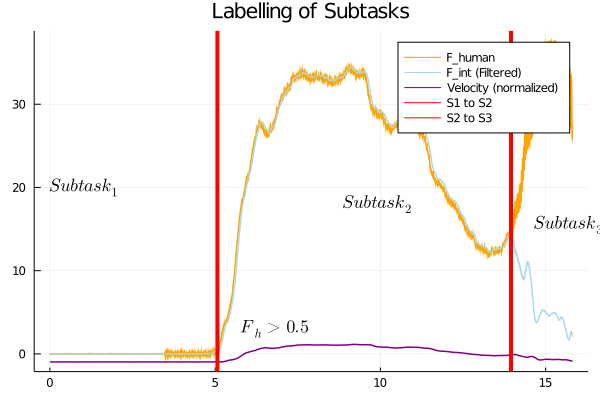

In [327]:
first_x_raw = x_raw_train[1:7907,:]
first_y_raw = train_data[1:7907,end];
sub1_sub2 = findall(x-> 3>x>1,first_y_raw)[1]
sub2_sub3 = findall(x-> x>2,first_y_raw)[1]
plot(first_x_raw[:,1],first_x_raw[:,4], title = "Labelling of Subtasks",  label = "F_human" ,lw = 1.5, fmt = :png, linecolor = "Orange")
plot!(first_x_raw[:,1],first_x_raw[:,3], label= "F_int (Filtered)", lw = 1.5, linecolor="LightBlue")
plot!(first_x_raw[:,1],x_train[1:7907,2], label= "Velocity (normalized)", lw = 1.5, linecolor="Purple")
plot!([first_x_raw[sub1_sub2,1]], seriestype="vline", lw = 4, linecolor = "Red", label ="S1 to S2")
plot!([first_x_raw[sub2_sub3,1]], seriestype="vline", lw = 4, linecolor = "Red", label ="S2 to S3")
annotate!(first_x_raw[sub1_sub2,1]+0.7, 3, text("\$F_h > 0.5 \$",Plots.font("Tahoma", 12),  :left))
annotate!(0, 20, text("\$Subtask_1 \$",Plots.font("Tahoma", 12),  :left))
annotate!(first_x_raw[sub1_sub2,1]+ 3.8, 18, text("\$Subtask_2 \$",Plots.font("Tahoma", 12),  :left))
annotate!(first_x_raw[sub2_sub3,1]+ 0.7, 15.5, text("\$Subtask_3 \$",Plots.font("Tahoma", 12),  :left))

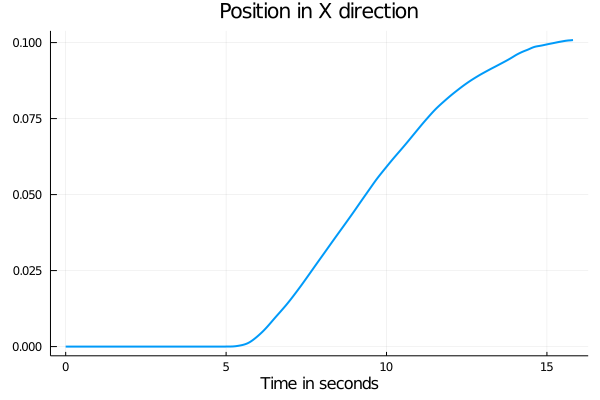

In [328]:
plot(train_data[1:7907,1],train_data[1:7907,2], title = "Position in X direction", label = false, lw = 2)
xlabel!("Time in seconds")

## MLP

### Custom Minibatch Function

In [329]:
dtrn2 = minibatch(x_train',y_train',64)
dtst2 = minibatch(x_test',y_test',64)

1168-element Data{Tuple{KnetArray{Float32,N} where N,KnetArray{Int64,N} where N}}

### Initializing the Parameters

In [330]:
function trainresults(dtrn,dtst,model; o...)
        r = ((model(dtrn), model(dtst), 1-accuracy(model,dtrn), 1-accuracy(model,dtst))
        for x in takenth(progress(sgd(model,ncycle(dtrn,80),lr = 0.001)),length(dtrn)))
        r = reshape(collect(Float32,flatten(r)),(4,:))
        GC.gc(true) # To save gpu memory
    println(minimum(r,dims=2))
    return r
end

trainresults (generic function with 2 methods)

In [331]:
param(d...; init=xavier_uniform, atype=array_type)=Param(atype(init(d...)))
param0(d...; atype=array_type)=param(d...; init=zeros, atype=atype)
xavier_uniform(o,i) = (s = sqrt(2/(i+o)); 2s .* rand(o,i) .- s)

xavier_uniform (generic function with 1 method)

In [332]:
# Let's define a chain of layers
struct Chain
    layers
    Chain(layers...) = new(layers)
end
(c::Chain)(x) = (for l in c.layers; x = l(x); end; x)
(c::Chain)(x,y) = nll(c(x),y)
(c::Chain)(d::Data) = mean(c(x,y) for (x,y) in d)

In [333]:
struct Layer0; w; b; end
Layer0(i::Int,o::Int) = Layer0(param(o,i),param0(o))
(l::Layer0)(x) = (l.w * x .+ l.b)

In [334]:
struct Layer2; w; b; f;  end
Layer2(i::Int,o::Int,f=relu;) = Layer2(param(o,i),param0(o),f)
(l::Layer2)(x) = l.f.(l.w * x .+ l.b)

In [335]:
model=Chain(Layer2(79,50),Layer2(50,50) ,Layer2(50,3))

Chain((Layer2(P(KnetArray{Float32,2}(50,79)), P(KnetArray{Float32,1}(50)), Knet.Ops20.relu), Layer2(P(KnetArray{Float32,2}(50,50)), P(KnetArray{Float32,1}(50)), Knet.Ops20.relu), Layer2(P(KnetArray{Float32,2}(3,50)), P(KnetArray{Float32,1}(3)), Knet.Ops20.relu)))

In [336]:
results = trainresults(dtrn2,dtst2,model)
send_message("Training has just finished!")

┣████████████████████┫ [100.00%, 107760/107760, 07:03/07:03, 254.58i/s] 


Float32[0.14720204; 0.14118348; 0.040089086; 0.044319883]


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

{}

100    29  100     2  100    27      2     27  0:00:01  0:00:01 --:--:--    19


Process(`curl https://notify.run/zrqfxE0M1ypL5Dv4 -d 'Training has just finished!'`, ProcessExited(0))

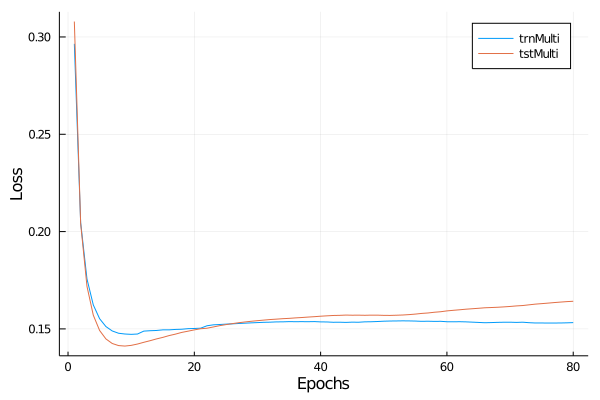

In [339]:
plot([results[1,:], results[2,:]],
    labels=[ "trnMulti" "tstMulti"],xlabel="Epochs",ylabel="Loss")  

In [338]:
results

4×80 Array{Float32,2}:
 0.296468   0.204598   0.175683   …  0.153044   0.153123   0.153233
 0.307919   0.204131   0.17187       0.163784   0.164023   0.164196
 0.0552037  0.0436966  0.0400891     0.0663975  0.0663859  0.0663975
 0.0652424  0.0607342  0.0574433     0.0445072  0.0443868  0.0443199